# Assignment 3: Image Classification

In this assignment, we will build a convolutional neural network that can predict
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network mostly by yourself.

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import sys
from PIL import Image

def reload_functions():
  if 'ML_DL_Functions3' in sys.modules:
    del sys.modules['ML_DL_Functions3']
  functions_path = drive_path.replace(" ","\ ") + 'ML_DL_Functions3.py'
  !cp $functions_path .

## 1. Data

Download the data from the course website. make sure you have both the template python functions file and the dataset data directory on the same directory in your google drive.

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive_path = '/content/gdrive/MyDrive/intro_to_machine_learning/HW3/' # TODO - UPDATE ME!
drive.mount('/content/gdrive')

Mounted at /content/gdrive


After you have done so, read this entire section
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### 1.1 Loading and Preprocessing the data

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair.
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `Image.open`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed.
**The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1.** Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

In [ ]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files

import glob

# Assuming 'data/train/*' could include both .jpg and .png files
train_person_number = (len(glob.glob(drive_path + "data/train/*.jpg")) + len(glob.glob(drive_path + "data/train/*.png"))) // 6
test_m_person_number = (len(glob.glob(drive_path + "data/test_m/*.jpg")) + len(glob.glob(drive_path + "data/test_m/*.png"))) // 6
test_w_person_number = (len(glob.glob(drive_path + "data/test_w/*.jpg")) + len(glob.glob(drive_path + "data/test_w/*.png"))) // 6


# Specify the path patterns for each folder
path_train_for_max = drive_path + "data/train/*"
path_test_m_for_max = drive_path + "data/test_m/*"
path_test_w_for_max = drive_path + "data/test_w/*"

# Initialize variables to store the maximum person ID for each folder
max_id_train = 0
max_id_test_m = 0
max_id_test_w = 0

# Process train folder
for filepath in glob.glob(path_train_for_max):
    filename = filepath.split("/")[-1]
    person_num = int(filename[1:4])
    max_id_train = max(max_id_train, person_num)

# Process test_m folder
for filepath in glob.glob(path_test_m_for_max):
    filename = filepath.split("/")[-1]
    person_num = int(filename[1:4])
    max_id_test_m = max(max_id_test_m, person_num)

# Process test_w folder
for filepath in glob.glob(path_test_w_for_max):
    filename = filepath.split("/")[-1]
    person_num = int(filename[1:4])
    max_id_test_w = max(max_id_test_w, person_num)


path_train = [drive_path + "data/train/*.jpg", drive_path + "data/train/*.png"]
path_test_m = [drive_path + "data/test_m/*.jpg", drive_path + "data/test_m/*.jpg"]
path_test_w = [drive_path + "data/test_w/*.jpg", drive_path + "data/test_w/*.jpg"]

train_data = np.empty((max_id_train, 3, 2, 224, 224, 3), dtype=np.float64)
test_data_m = np.empty((max_id_test_m, 3, 2, 224, 224, 3), dtype=np.float64)
test_data_w = np.empty((max_id_test_w, 3, 2, 224, 224, 3), dtype=np.float64)

for path in path_train:
  for file in glob.glob(path):
      filename = file.split("/")[-1]                            # get the name of the .jpg file                               # to seperate person_id, shoe_pair, and left or right
      person_num = int(filename[1:4])-1                         # Convert user ID to integer, removing the 'u' prefix
      pair_num = int(filename[5])-1                             # get the pair number
      shoe_side = 0 if 'left' in filename else 1                # convert left or right to 0 and 1
      img = np.asarray(Image.open(file))[:, :, :3]              ## load the picture, remove the alpha channel and convert to np
      img = img / 255.0 - 0.5                                   ## Normalize
      train_data[person_num, pair_num, shoe_side] = img

for path in path_test_m:
  for file in glob.glob(path):
      filename = file.split("/")[-1]                            # get the name of the .jpg file                               # to seperate person_id, shoe_pair, and left or right
      person_num = int(filename[1:4])-1                         # Convert user ID to integer, removing the 'u' prefix
      pair_num = int(filename[5])-1                             # get the pair number
      shoe_side = 0 if 'left' in filename else 1                # convert left or right to 0 and 1
      img = np.asarray(Image.open(file))[:, :, :3]              ## load the picture, remove the alpha channel and convert to np
      img = img / 255.0 - 0.5                                   ## Normalize
      test_data_m[person_num, pair_num, shoe_side] = img
for path in path_test_w:
  for file in glob.glob(path):
      filename = file.split("/")[-1]                            # get the name of the .jpg file                               # to seperate person_id, shoe_pair, and left or right
      person_num = int(filename[1:4])-1                         # Convert user ID to integer, removing the 'u' prefix
      pair_num = int(filename[5])-1                             # get the pair number
      shoe_side = 0 if 'left' in filename else 1                # convert left or right to 0 and 1
      img = np.asarray(Image.open(file))[:, :, :3]              ## load the picture, remove the alpha channel and convert to np
      img = img / 255.0 - 0.5                                   ## Normalize
      test_data_w[person_num, pair_num, shoe_side] = img


train_data_zero_points_indexes = np.nonzero(np.any(train_data != 0, axis=(3, 4, 5)))
train_data_cleaned = train_data[train_data_zero_points_indexes]
train_data = train_data_cleaned.reshape(train_person_number, 3, 2, 224, 224, 3)


test_data_m_zero_points_inexes = np.nonzero(np.any(test_data_m != 0, axis=(3, 4, 5)))
test_data_m_cleaned = test_data_m[test_data_m_zero_points_inexes]
test_data_m = test_data_m_cleaned.reshape(test_m_person_number, 3, 2, 224, 224, 3)


test_data_w_zero_points_inexes = np.nonzero(np.any(test_data_w != 0, axis=(3, 4, 5)))
test_data_w_cleaned = test_data_w[test_data_w_zero_points_inexes]
test_data_w = test_data_w_cleaned.reshape(test_w_person_number, 3, 2, 224, 224, 3)


slicing_idx = int(0.8*(len(train_data)))
valid_data = train_data[slicing_idx:]
train_data = train_data[:slicing_idx]


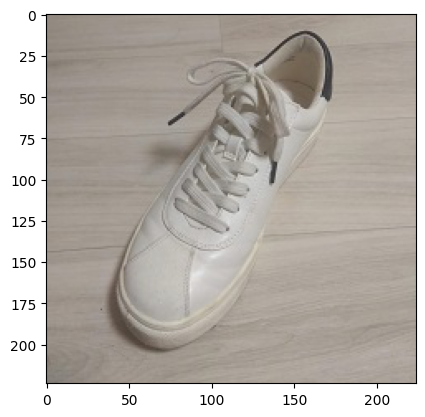

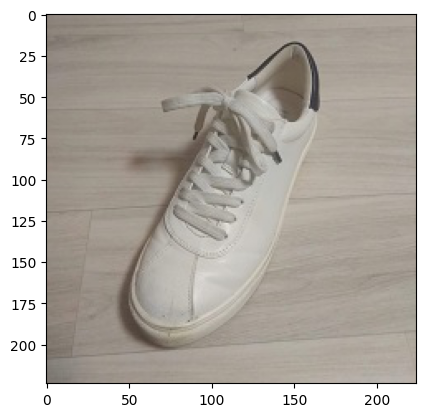

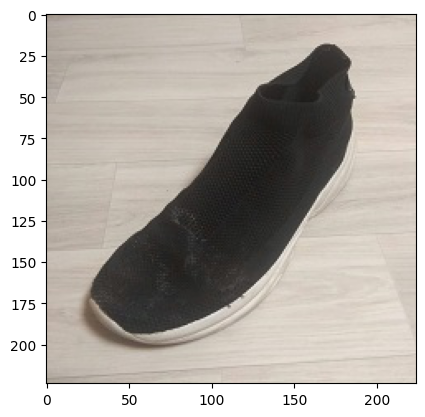

In [ ]:
# Run this code
test1 = np.load(drive_path+"data/preproccessing_validation/preproccessing_validation_test1.npy")
test2 = np.load(drive_path+"data/preproccessing_validation/preproccessing_validation_test2.npy")
test3 = np.load(drive_path+"data/preproccessing_validation/preproccessing_validation_test3.npy")
if (test1 != train_data[4,0,0,:,:,:]).any() or \
   (test2 != train_data[4,0,1,:,:,:]).any() or \
   (test3 != train_data[4,1,1,:,:,:]).any():
   print("preprocessing error, make sure you followed all instructions carefully")

plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]+0.5) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]+0.5) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]+0.5) # right shoe of second pair submitted by 5th student

### 1.2 Generating Same Pairs

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(90, 3, 2, 224, 224, 3)
(270, 448, 224, 3)


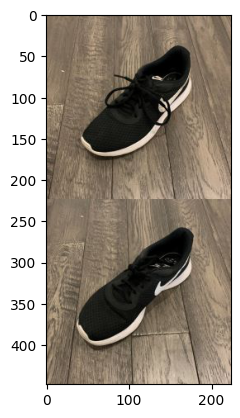

In [ ]:
# Your code goes here
def generate_same_pair(data):
    num_persons, num_pairs, num_shoes, height, width, channels = data.shape
    same_pairs = np.empty((num_persons * num_pairs, 448, 224, 3), dtype=np.float32)

    index = 0
    for person in range(num_persons):
        for pair in range(num_pairs):
            left_shoe = data[person, pair, 0, :, :, :]
            right_shoe = data[person, pair, 1, :, :, :]
            concatenated_pair = np.vstack((left_shoe, right_shoe))
            same_pairs[index] = concatenated_pair
            index += 1

    return same_pairs

# Run this code
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]+0.5) # should show 2 shoes from the same pair

### 1.3 Generate Different Pairs

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(90, 3, 2, 224, 224, 3)
(270, 448, 224, 3)


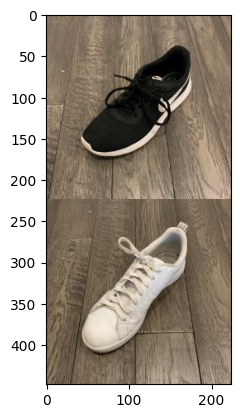

In [ ]:
# Your code goes here

import numpy as np
import random
# creates shoes pairs (left shoe, right shoe) of different shoes of the same person
def generate_different_pair(data):
    N = data.shape[0]
    wrong_pairs = np.empty((N * 3, 448, 224, 3), dtype=np.float32)
    combinations = [(0, 1), (0, 2), (1,0), (1, 2), (2,0), (2,1)]
    idx = 0
    for person in range(N):
        selected_combinations = random.sample(combinations, 3)                   # generate 3 possible combinations for wrong pairs for each person
        for first_pair, second_pair in selected_combinations:
            left_shoe = data[person, first_pair, 0, :, :, :]      # select left shoe from one pair and right shoe from another
            right_shoe = data[person, second_pair, 1, :, :, :]
            wrong_pair_img = np.vstack((left_shoe, right_shoe))   # concatenate along the height axis
            wrong_pairs[idx, :, :, :] = wrong_pair_img
            idx += 1

    return wrong_pairs

# Run this code
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0]+0.5) # should show 2 shoes from different pairs

#### Food for thought

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

## 2. Convolutional Neural Networks

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.



### 2.1 Convolutional Model

Open the functions file(ML_DL_Functions3.py) and Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

make sure the CNN's constructor(__init__) function has no arguments. Instantiate the variable $n$ inside the constructor(__init__) of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.
make sure the output of the model has a shape of (N,2) where N is the batch_size.

### 2.2 Channeled Convolutional Neural Network

Open the functions file(ML_DL_Functions3.py) and Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

make sure the output of the model has a shape of (N,2) where N is the batch_size.

#### Food for thought

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. why would one of these models perform better?

### 2.3 Get Accuracy

The function `get_accuracy` is written for you.

Unlike in the previous assignment, here we will separately compute the model accuracy on the
positive and negative samples.

In [ ]:
def get_accuracy(model, data, batch_size=50,device='cpu'):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).permute(0,3,1,2)
        xs = xs.to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        pos_correct += (pred == 1).sum()

    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).permute(0,3,1,2)
        xs = xs.to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

#### Food for thought
why do we wish to track the false positives and false negatives separately?

## 3. Training

Now, we will write the functions required to train the model.

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target. We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### 3.1 train model

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image.
- computing the forward and backward passes
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch.

In [ ]:
# you can change the signature and structure of this function as you please
# the code and comments below are only a suggestion to get you started
def train_model(model,
                train_data=train_data,
                validation_data=valid_data,
                batch_size=50,
                learning_rate=0.001,
                weight_decay=0,
                epochs=10,
                checkpoint_path=None):

  # device = torch.device("cpu")
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  pos_acc_train_list, neg_acc_train_list,  pos_acc_valid_list, neg_acc_valid_list = [], [], [], []
  lost_list, absolut_train_acc_list, absolut_valid_acc_list =[], [], []
  # Initialize Loss function and optimizer
  # ...
  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  # Create the positive and negative pairs
  # ...
  positive_pairs = generate_same_pair(train_data)      # should have shape [n * 3, 448, 224, 3]
  negative_pairs = generate_different_pair(train_data)


  best_valid_acc = 0
  best_epoch = 0
  for epoch in range(epochs):
    # shuffle the positive and negative pairs
    # ...
    shuffled_indices_pos = torch.randperm(len(positive_pairs))
    positive_pairs = positive_pairs[shuffled_indices_pos]

    shuffled_indices_neg = torch.randperm(len(negative_pairs))
    negative_pairs = negative_pairs[shuffled_indices_neg]

    total_batches = 0
    accumulated_loss = 0.0

    for i in range(0,len(positive_pairs),batch_size//2):
      #...
      # sample batch_size//2 of positive pairs and batch_size//2 of negative pairs
      # ...
      batch_pos = positive_pairs[i:i + batch_size // 2]
      batch_neg = negative_pairs[i:i + batch_size // 2]

      # Create the labels of the batch and combine the positive and negative half batches
      # ...
      batch_pos_labels = np.ones(batch_size // 2, dtype=int)
      batch_neg_labels = np.zeros(batch_size // 2, dtype=int)

      batch_samples = np.concatenate((batch_pos, batch_neg), axis=0)
      batch_labels = np.concatenate((batch_pos_labels, batch_neg_labels), axis=0)
      # Conversion from numpy array to torch tensor (if working with gpu also change device to gpu)
      # ...
      batch_samples = torch.tensor(batch_samples, dtype=torch.float32).permute(0,3,1,2).to(device)
      batch_labels = torch.tensor(batch_labels, dtype=torch.long).to(device)
      # ... # Reset the optimizer
      optimizer.zero_grad()
      # ... # Predict output
      model.train()
      outputs = model(batch_samples)
      # ... # Compute the loss
      loss = loss_func(outputs, batch_labels)
      # ... # Backward pass
      loss.backward()
      # ... # Update the parameters
      optimizer.step()
      ###
      accumulated_loss += loss.item()
      total_batches += 1
      ###
    # track the accuracy and loss of the training and validation
    # ...
    train_loss = accumulated_loss / total_batches
    lost_list.append(train_loss)
    model.eval()
    model.cpu()
    pos_acc_train, neg_acc_train = get_accuracy(model, train_data)
    pos_acc_valid, neg_acc_valid = get_accuracy(model, validation_data)
    model.to(device)
    model.train()

    absolut_train_accuracy = (pos_acc_train+neg_acc_train)/2
    absolut_valid_accuracy = (pos_acc_valid+neg_acc_valid)/2
    pos_acc_train_list.append(pos_acc_train)
    neg_acc_train_list.append(neg_acc_train)
    pos_acc_valid_list.append(pos_acc_valid)
    neg_acc_valid_list.append(neg_acc_valid)
    absolut_train_acc_list.append(absolut_train_accuracy)
    absolut_valid_acc_list.append(absolut_valid_accuracy)

    print("Epoch %d:\n Train Acc: Pos: %.0f%%, Neg: %.0f%%, Absolut acc: %.0f%%\n Val Acc:   Pos: %.0f%%, Neg: %.0f%%, Absolut acc: %.0f%%\n Loss: %f\n" %
          (epoch+1, pos_acc_train * 100 ,neg_acc_train * 100, absolut_train_accuracy * 100, pos_acc_valid * 100, neg_acc_valid * 100, absolut_valid_accuracy * 100, train_loss))
    # checkpoint the model
    # ...
    if absolut_valid_accuracy > best_valid_acc:
      best_valid_acc = absolut_valid_accuracy
      best_epoch = epoch + 1
      best_checkpoint = {
      'epoch': epoch+1,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss.item(),
      }
      if checkpoint_path:
        torch.save(model.state_dict(), f'{checkpoint_path}_best.pth')
    # if checkpoint_path:
    #   torch.save(model.state_dict(), f'{checkpoint_path}_epoch_{epoch+1}.pth')




  # Create the x-axis values
  x = range(1, epochs+1)

  plt.figure(figsize=(8, 6))
  plt.plot(x, lost_list, 'b-', label='Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training Curve')
  plt.show()
  plt.figure(figsize=(8, 6))
  plt.plot(x, absolut_train_acc_list, 'r-', label='Average Accuracy (Train)')
  plt.plot(x, absolut_valid_acc_list, '-', label='Average Accuracy (Validation)')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Average Accuracy (Train & Validation)')
  plt.legend()
  # Add a title for the entire plot
  plt.suptitle("Validation Accuracy per Iteration; $\\mu$=" + str(learning_rate) +" Weight Decay=" + str(weight_decay) + " Batch Size=" + str(batch_size), fontsize=14)

  # Show all figures
  plt.show()

  return model,pos_acc_train_list,neg_acc_train_list,pos_acc_valid_list,neg_acc_valid_list,lost_list, best_checkpoint


### 3.2 Sanity check

Sanity check your code from 3.1 and from 2.1 and 2.2 by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ training accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

Epoch 1:
 Train Acc: Pos: 100%, Neg: 0%, Absolut acc: 50%
 Val Acc:   Pos: 100%, Neg: 0%, Absolut acc: 50%
 Loss: 0.804150

Epoch 2:
 Train Acc: Pos: 100%, Neg: 0%, Absolut acc: 50%
 Val Acc:   Pos: 100%, Neg: 0%, Absolut acc: 50%
 Loss: 0.551369

Epoch 3:
 Train Acc: Pos: 100%, Neg: 0%, Absolut acc: 50%
 Val Acc:   Pos: 100%, Neg: 0%, Absolut acc: 50%
 Loss: 0.424073

Epoch 4:
 Train Acc: Pos: 100%, Neg: 0%, Absolut acc: 50%
 Val Acc:   Pos: 100%, Neg: 0%, Absolut acc: 50%
 Loss: 0.364952

Epoch 5:
 Train Acc: Pos: 100%, Neg: 0%, Absolut acc: 50%
 Val Acc:   Pos: 100%, Neg: 0%, Absolut acc: 50%
 Loss: 0.311559

Epoch 6:
 Train Acc: Pos: 100%, Neg: 0%, Absolut acc: 50%
 Val Acc:   Pos: 100%, Neg: 0%, Absolut acc: 50%
 Loss: 0.240592

Epoch 7:
 Train Acc: Pos: 100%, Neg: 0%, Absolut acc: 50%
 Val Acc:   Pos: 100%, Neg: 0%, Absolut acc: 50%
 Loss: 0.216513

Epoch 8:
 Train Acc: Pos: 100%, Neg: 0%, Absolut acc: 50%
 Val Acc:   Pos: 100%, Neg: 0%, Absolut acc: 50%
 Loss: 0.206072

Epoch 9:

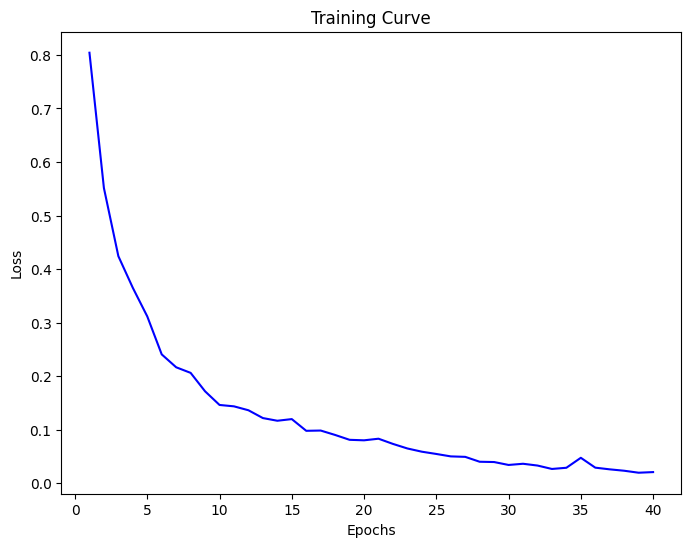

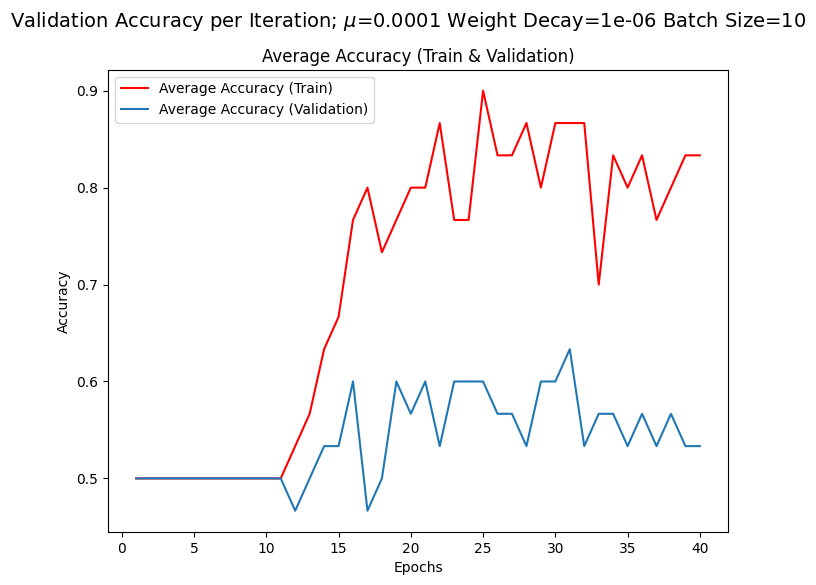

Epoch 1:
 Train Acc: Pos: 100%, Neg: 0%, Absolut acc: 50%
 Val Acc:   Pos: 100%, Neg: 0%, Absolut acc: 50%
 Loss: 1.081224

Epoch 2:
 Train Acc: Pos: 100%, Neg: 0%, Absolut acc: 50%
 Val Acc:   Pos: 100%, Neg: 0%, Absolut acc: 50%
 Loss: 0.913583

Epoch 3:
 Train Acc: Pos: 100%, Neg: 0%, Absolut acc: 50%
 Val Acc:   Pos: 100%, Neg: 0%, Absolut acc: 50%
 Loss: 0.702701

Epoch 4:
 Train Acc: Pos: 100%, Neg: 0%, Absolut acc: 50%
 Val Acc:   Pos: 100%, Neg: 0%, Absolut acc: 50%
 Loss: 0.528285

Epoch 5:
 Train Acc: Pos: 100%, Neg: 0%, Absolut acc: 50%
 Val Acc:   Pos: 100%, Neg: 0%, Absolut acc: 50%
 Loss: 0.432651

Epoch 6:
 Train Acc: Pos: 100%, Neg: 0%, Absolut acc: 50%
 Val Acc:   Pos: 100%, Neg: 0%, Absolut acc: 50%
 Loss: 0.369028

Epoch 7:
 Train Acc: Pos: 100%, Neg: 0%, Absolut acc: 50%
 Val Acc:   Pos: 100%, Neg: 0%, Absolut acc: 50%
 Loss: 0.313861

Epoch 8:
 Train Acc: Pos: 100%, Neg: 0%, Absolut acc: 50%
 Val Acc:   Pos: 100%, Neg: 0%, Absolut acc: 50%
 Loss: 0.236406

Epoch 9:

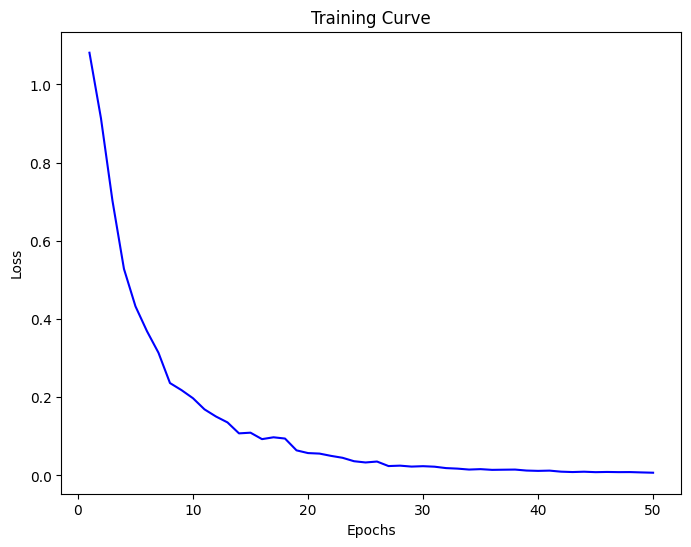

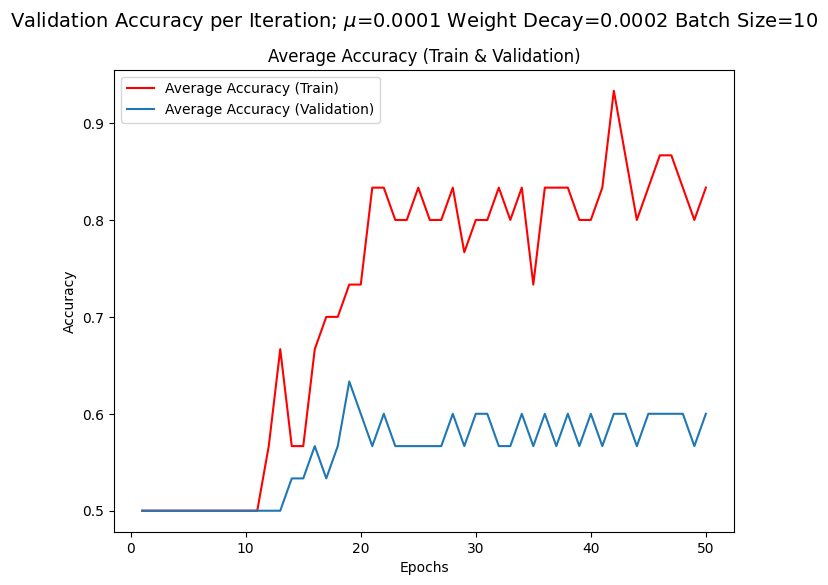

In [ ]:
reload_functions()
import ML_DL_Functions3

CNNChannel_model = ML_DL_Functions3.CNNChannel()
learning_rate = 0.0001
weight_decay = 0.000001
batch_size = 10
epochs = 40
test_train = train_data[0:5]
test_valid = valid_data[0:5]

model,pos_acc_train_list,neg_acc_train_list,pos_acc_valid_list,neg_acc_valid_list,lost_list, best_checkpoint = train_model(CNNChannel_model,test_train,test_valid,batch_size,learning_rate,weight_decay,epochs)

CNN_class = ML_DL_Functions3.CNN()
test_train = train_data[0:5]
test_valid = valid_data[0:5]
batch_size = 10
learning_rate = 0.0001
weight_decay = 0.0002  #the best
epochs = 50

model,pos_acc_train_list,neg_acc_train_list,pos_acc_valid_list,neg_acc_valid_list,lost_list, best_checkpoint = train_model(CNN_class,test_train,test_valid,batch_size,learning_rate,weight_decay,epochs)


# Write your code here. Remember to include your results so that we can
# see that your model attains a high training accuracy.




### 3.3 training and saving the optimal model

Train your models from Q2(a) and Q2(b). Change the values of a few
hyperparameters, including the learning rate, batch size, choice of $n$, and
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, choose your hyperparameters run the training and save the model in the drive. You should try to save the your **single best** model.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using.  Remember to submit the model with your code in the moodle submission.

It is recommended to plot the training curves.

Epoch 1:
 Train Acc: Pos: 0%, Neg: 100%, Absolut acc: 50%
 Val Acc:   Pos: 0%, Neg: 100%, Absolut acc: 50%
 Loss: 0.828179

Epoch 2:
 Train Acc: Pos: 100%, Neg: 1%, Absolut acc: 50%
 Val Acc:   Pos: 100%, Neg: 0%, Absolut acc: 50%
 Loss: 0.693181

Epoch 3:
 Train Acc: Pos: 74%, Neg: 41%, Absolut acc: 57%
 Val Acc:   Pos: 67%, Neg: 51%, Absolut acc: 59%
 Loss: 0.628934

Epoch 4:
 Train Acc: Pos: 94%, Neg: 49%, Absolut acc: 71%
 Val Acc:   Pos: 97%, Neg: 41%, Absolut acc: 69%
 Loss: 0.566344

Epoch 5:
 Train Acc: Pos: 95%, Neg: 58%, Absolut acc: 77%
 Val Acc:   Pos: 94%, Neg: 51%, Absolut acc: 72%
 Loss: 0.493180

Epoch 6:
 Train Acc: Pos: 97%, Neg: 65%, Absolut acc: 81%
 Val Acc:   Pos: 96%, Neg: 58%, Absolut acc: 77%
 Loss: 0.429466

Epoch 7:
 Train Acc: Pos: 99%, Neg: 67%, Absolut acc: 83%
 Val Acc:   Pos: 96%, Neg: 61%, Absolut acc: 78%
 Loss: 0.364445

Epoch 8:
 Train Acc: Pos: 94%, Neg: 74%, Absolut acc: 84%
 Val Acc:   Pos: 94%, Neg: 64%, Absolut acc: 79%
 Loss: 0.313468

Epoch 9:

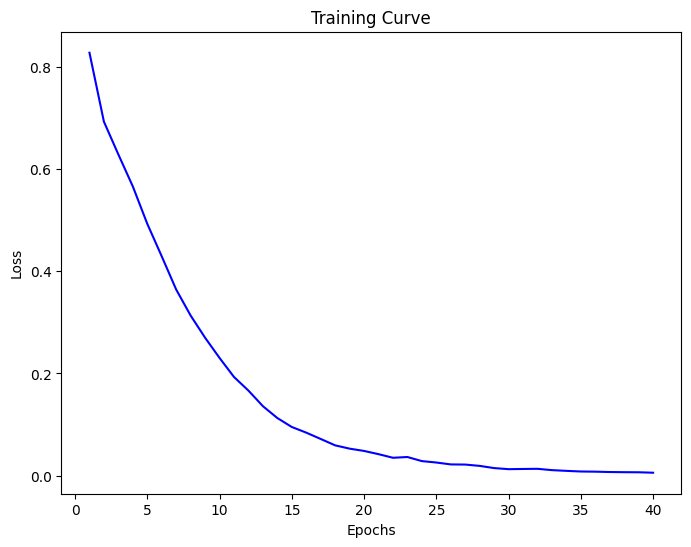

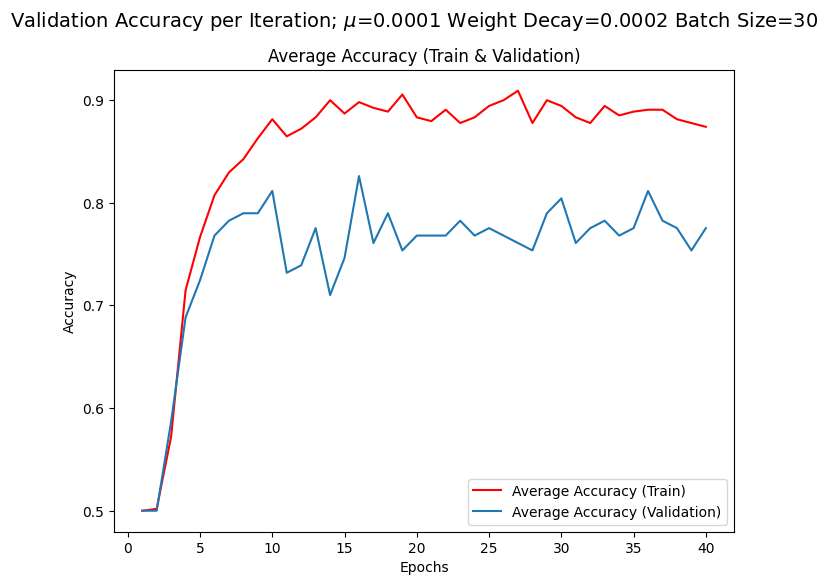

Epoch 1:
 Train Acc: Pos: 82%, Neg: 28%, Absolut acc: 55%
 Val Acc:   Pos: 80%, Neg: 32%, Absolut acc: 56%
 Loss: 0.722234

Epoch 2:
 Train Acc: Pos: 14%, Neg: 96%, Absolut acc: 55%
 Val Acc:   Pos: 14%, Neg: 93%, Absolut acc: 54%
 Loss: 0.546803

Epoch 3:
 Train Acc: Pos: 8%, Neg: 100%, Absolut acc: 54%
 Val Acc:   Pos: 6%, Neg: 97%, Absolut acc: 51%
 Loss: 0.457380

Epoch 4:
 Train Acc: Pos: 68%, Neg: 94%, Absolut acc: 81%
 Val Acc:   Pos: 48%, Neg: 87%, Absolut acc: 67%
 Loss: 0.376162

Epoch 5:
 Train Acc: Pos: 82%, Neg: 93%, Absolut acc: 87%
 Val Acc:   Pos: 58%, Neg: 81%, Absolut acc: 70%
 Loss: 0.304806

Epoch 6:
 Train Acc: Pos: 96%, Neg: 85%, Absolut acc: 90%
 Val Acc:   Pos: 88%, Neg: 64%, Absolut acc: 76%
 Loss: 0.245719

Epoch 7:
 Train Acc: Pos: 99%, Neg: 76%, Absolut acc: 88%
 Val Acc:   Pos: 91%, Neg: 72%, Absolut acc: 82%
 Loss: 0.202806

Epoch 8:
 Train Acc: Pos: 97%, Neg: 84%, Absolut acc: 91%
 Val Acc:   Pos: 83%, Neg: 77%, Absolut acc: 80%
 Loss: 0.160233

Epoch 9:


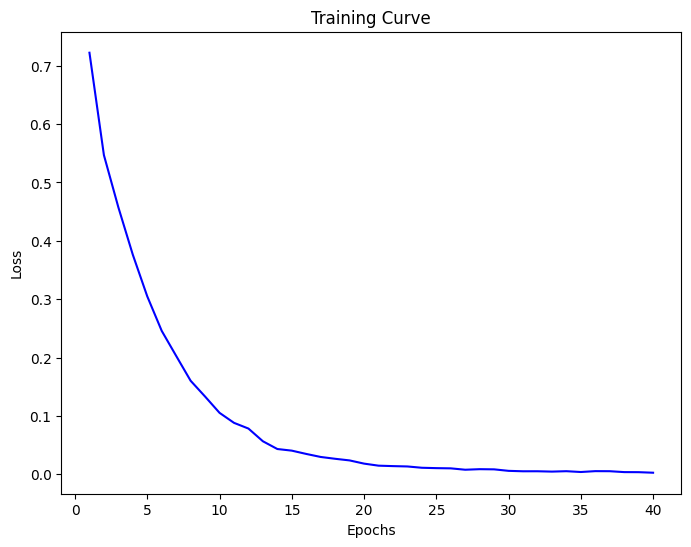

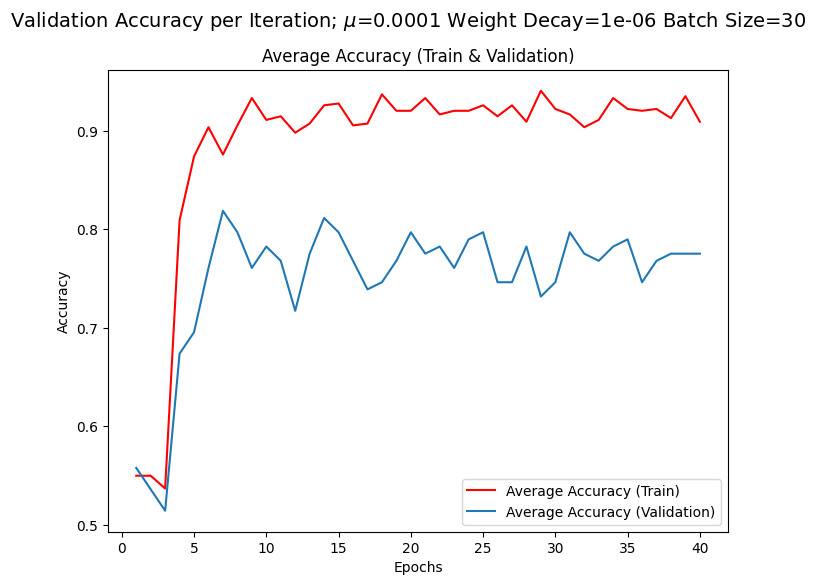

In [ ]:
reload_functions()
import ML_DL_Functions3
CNN_model = ML_DL_Functions3.CNN() # this has to be the blueprint for the model(don't add arguments)
CNNChannel_model = ML_DL_Functions3.CNNChannel() # this has to be the blueprint for the model(don't add arguments)

# CNN

batch_size = 30
learning_rate = 0.0001
weight_decay = 0.0002
epochs = 40

checkpoint_path = drive_path + "checkpoints/" + "CNN_model"
checkpoint_path = None

CNN_model,pos_acc_train_list_CNN,neg_acc_train_list_CNN,pos_acc_valid_list_CNN,neg_acc_valid_list_CNN,lost_list_CNN, best_checkpoint = train_model(CNN_model,train_data,valid_data,batch_size,learning_rate,weight_decay,epochs, checkpoint_path=checkpoint_path)

CNN_model.load_state_dict(torch.load(f'{checkpoint_path}_best.pth'))


# CNN channel
batch_size = 30
learning_rate = 0.0001
weight_decay = 0.000001
epochs = 40


checkpoint_path = drive_path + "checkpoints/" + "CNNChannel_model"
checkpoint_path = None

CNNChannel_model,pos_acc_train_list_CNN,neg_acc_train_list_CNN,pos_acc_valid_list_CNN,neg_acc_valid_list_CNN,lost_list_CNN,best_checkpoint = train_model(CNNChannel_model,train_data, valid_data ,batch_size,learning_rate,weight_decay,epochs, checkpoint_path=checkpoint_path)

CNNChannel_model.load_state_dict(torch.load(f'{checkpoint_path}_best.pth'))

In [ ]:
# Run the following code and submit to the moodle the two models saved
CNNChannel_model = ML_DL_Functions3.CNNChannel()
checkpoint_path = drive_path + "checkpoints/" + "CNNChannel_model"
CNNChannel_model.load_state_dict(torch.load(f'{checkpoint_path}_best.pth', map_location=torch.device('cpu')))

CNN_model = ML_DL_Functions3.CNN()
checkpoint_path = drive_path + "checkpoints/" + "CNN_model"
CNN_model.load_state_dict(torch.load(f'{checkpoint_path}_best.pth', map_location=torch.device('cpu') ))

checkpoint_path  = drive_path+"checkpoints/" # you can change the path
torch.save(CNN_model.state_dict(), checkpoint_path+"best_CNN_model.pk") # Do not change the name of the checkpoint file
torch.save(CNNChannel_model.state_dict(), checkpoint_path+"best_CNNChannel_model.pk") # Do not change the name of the checkpoint file

## 4. Testing


This part is mainly to help you get a feeling of your models performance. It should not take you long to finish.

### 4.1. Accuracies

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [ ]:
reload_functions()
import ML_DL_Functions3
# Write your code here.

CNNChannel_model = ML_DL_Functions3.CNNChannel()
checkpoint_path = drive_path + "checkpoints/" + "CNNChannel_model"
CNNChannel_model.load_state_dict(torch.load(f'{checkpoint_path}_best.pth', map_location=torch.device('cpu')))

# CNN_model = ML_DL_Functions3.CNN()
# checkpoint_path = drive_path + "checkpoints/" + "CNN_model"
# CNN_model.load_state_dict(torch.load(f'{checkpoint_path}_best.pth',  map_location=torch.device('cpu')))

# CNN_model.eval()
CNNChannel_model.eval()

CNNChannel_acc_men = 0
CNNChannel_acc_women = 0

# CNN_acc_men = 0
# CNN_acc_women = 0

iterations = 20

for _ in range(iterations):
  test_m_CNNChannel_pos_acc, test_m_CNNChannel_neg_acc = get_accuracy(CNNChannel_model, test_data_m)
  test_m_CNNChannel_acc = (test_m_CNNChannel_pos_acc + test_m_CNNChannel_neg_acc) / 2
  CNNChannel_acc_men += test_m_CNNChannel_acc

  test_w_CNNChannel_pos_acc, test_w_CNNChannel_neg_acc = get_accuracy(CNNChannel_model, test_data_w)
  test_w_CNNChannel_acc = (test_w_CNNChannel_pos_acc + test_w_CNNChannel_neg_acc) / 2
  CNNChannel_acc_women += test_w_CNNChannel_acc

  # test_m_CNN_pos_acc, test_m_CNN_neg_acc = get_accuracy(CNN_model, test_data_m)
  # test_m_CNN_acc = (test_m_CNN_pos_acc + test_m_CNN_neg_acc) / 2
  # CNN_acc_men += test_m_CNN_acc

  # test_w_CNN_pos_acc, test_w_CNN_neg_acc = get_accuracy(CNN_model, test_data_w)
  # test_w_CNN_acc = (test_w_CNN_pos_acc + test_w_CNN_neg_acc) / 2
  # CNN_acc_women += test_w_CNN_acc

CNNChannel_avg_acc_men = CNNChannel_acc_men / iterations
CNNChannel_avg_acc_women = CNNChannel_acc_women / iterations

# CNN_avg_acc_men = CNN_acc_men / iterations
# CNN_avg_acc_women = CNN_acc_women / iterations

print('CNNChannel Accuracy on men data: ' + str(CNNChannel_avg_acc_men))
print('CNNChannel Accuracy on men women: ' + str(CNNChannel_avg_acc_women))
# print('CNN Accuracy on men data: ' + str(CNN_avg_acc_men))
# print('CNN Accuracy on men women: ' + str(CNN_avg_acc_women))


CNNChannel Accuracy on men data: 0.7933333333333332
CNNChannel Accuracy on men women: 0.8641666666666667


Notice that this testing has a random element to it, depending on which images where chosen in the generate pairs. In order to grade your code the testing will be run multiple times to reduce the randomness.

### 4.2 Men's Shoes example

Display one set of men's shoes that your model correctly classified as being
from the same pair.

display one set of inputs that your model classified incorrectly.


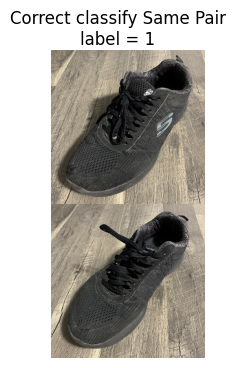

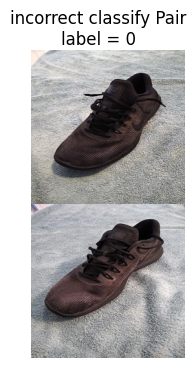

In [ ]:
# Write your code here.


def find_correct_incorrect_examples(model, data, device='cpu'):

  model.eval()  # Ensure the model is in evaluation mode

  # Generate pairs
  same_pairs = generate_same_pair(data)  # Your function to generate same pairs
  diff_pairs = generate_different_pair(data)  # Your function to generate different pairs

  shuffled_indices_pos = torch.randperm(len(same_pairs))
  same_pairs = same_pairs[shuffled_indices_pos]
  shuffled_indices_neg = torch.randperm(len(diff_pairs))
  diff_pairs = diff_pairs[shuffled_indices_neg]



  correct_same_example = None
  incorrect_example = None

  with torch.no_grad():  # No gradient needed for evaluation
      for pair in same_pairs:
          xs = torch.Tensor(pair).unsqueeze(0).permute(0, 3, 1, 2).to(device)
          zs = model(xs)
          pred = zs.max(1, keepdim=True)[1].item()
          if pred == 1:  # Assuming 1 represents 'same'
              correct_same_example = pair
              correct_label = pred
              break  # Stop after finding the first correct same pair

      shuffled_indices_pos = torch.randperm(len(same_pairs))
      same_pairs = same_pairs[shuffled_indices_pos]

      for pair in same_pairs:
          xs = torch.Tensor(pair).unsqueeze(0).permute(0, 3, 1, 2).to(device)
          zs = model(xs)
          pred = zs.max(1, keepdim=True)[1].item()
          if pred == 0:  # Assuming 1 represents 'same'
              incorrect_example = pair
              incorrect_label = pred
              break  # Stop after finding the first correct same pair

      if incorrect_example is None:
        for pair in diff_pairs:
          xs = torch.Tensor(pair).unsqueeze(0).permute(0, 3, 1, 2).to(device)
          zs = model(xs)
          pred = zs.max(1, keepdim=True)[1].item()
          if pred == 1:  # Assuming 1 represents 'same'
              incorrect_example = pair
              incorrect_label = pred
              break  # Stop after finding the first correct same pair


  return correct_same_example, incorrect_example, correct_label, incorrect_label

# Function to display a shoe pair
def display_shoe_pair(pair, title="Shoe Pair"):
    """Displays a shoe pair with matplotlib."""
    plt.figure(figsize=(8, 4))
    plt.imshow(pair + 0.5)  # Assuming normalization to [-0.5, 0.5]
    plt.axis('off')
    plt.suptitle(title)
    plt.show()

model = ML_DL_Functions3.CNNChannel()
model.load_state_dict(torch.load(f'{checkpoint_path}_best.pth', map_location=torch.device('cpu')))
data = test_data_m
correct_same_example, incorrect_example,correct_label, incorrect_label = find_correct_incorrect_examples(model, data)
# Display the examples, if found

if correct_same_example is not None:
    display_shoe_pair(correct_same_example, "Correct classify Same Pair\n" + "label = " + str(correct_label))

if incorrect_example is not None:
    display_shoe_pair(incorrect_example, "incorrect classify Pair\n" + "label = " + str(incorrect_label))



### 4.2 Women's Shoes example

Display one set of women's shoes that your model correctly classified as being
from the same pair.

display one set of inputs that your model classified incorrectly.

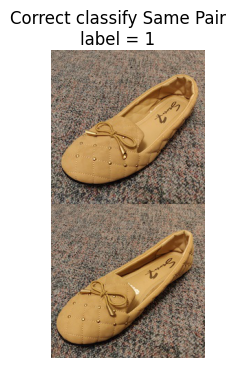

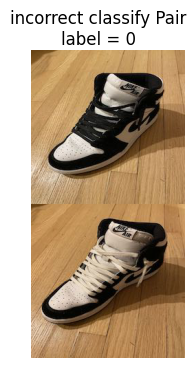

In [ ]:
# Write your code here.
model = ML_DL_Functions3.CNNChannel()
model.load_state_dict(torch.load(f'{checkpoint_path}_best.pth', map_location=torch.device('cpu')))
data = test_data_w
correct_same_example, incorrect_example, correct_label, incorrect_label = find_correct_incorrect_examples(model, data)
# Display the examples, if found

if correct_same_example is not None:
    display_shoe_pair(correct_same_example, "Correct classify Same Pair\n" + "label = " + str(correct_label))

if incorrect_example is not None:
    display_shoe_pair(incorrect_example, "incorrect classify Pair\n" + "label = " + str(incorrect_label))